# TODO:

- [x] Simulate based on monthly values
- [x] Optimization update every month - compare with the DAI
- [x] Rebalance portfolio after each day or something
- [x] Add interest rate on DAI

In [1]:
# # Get historical data from binance
# from binance_historical_data import BinanceDataDumper
# from pathlib import Path

# data_dumper = BinanceDataDumper(
#     path_dir_where_to_dump="../data/dump",
#     asset_class="spot",  # spot, um, cm
#     data_type="klines",  # aggTrades, klines, trades
#     data_frequency="1h",
# )

# exclude = []
# for p in Path("../data/dump/spot/monthly/klines").glob("*"):
#     exclude.append(p.name)

# data_dumper.dump_data(tickers_to_exclude=exclude)

In [2]:
from pathlib import Path
from datetime import datetime
from enum import Enum

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_t, norm, t
import numpy as np
from scipy import special
from pypfopt import (
    EfficientFrontier,
    EfficientSemivariance,
    EfficientCVaR,
    expected_returns,
    risk_models,
    plotting, # Need to fix bug in the library
)

def set_style(size=(12, 9)):
    sns.set(rc={'figure.figsize':size})
    sns.set_style("whitegrid")

set_style()

# Monte carlo: https://github.com/GreatSoshiant/Monte-Carlo/blob/master/Code/Monte-Carlo.py


data_folder = Path("../data")

class DataType(Enum):
    MINUTE = 1  # Minute data collected by Daniel
    HOUR = 2    # Hour data from the cryptodatadownload.com

# Pick data you want to use:
SELECTED_DATA = DataType.HOUR

/tmp/ipykernel_268504/2215027528.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Mapping symbol to tags
symbol_tags = {}
symbols = []
with (data_folder / "symbolTags.txt").open() as f:
    for line in f:
        symbol, tags = line.strip().split(":")
        symbol_tags[symbol] = tags.split(",")
        symbols.append(symbol)

# print(symbol_tags)

names = []
with (data_folder / "nameTags.txt").open() as f:
    for line in f:
        name, _ = line.strip().split(":")
        names.append(name)

symbol_to_name = dict(zip(symbols, names))

# Mapping tags to symbol
tag_groups = {}
for symbol, tags in symbol_tags.items():
    for tag in tags:
        if tag not in tag_groups:
            tag_groups[tag] = []
        tag_groups[tag].append(symbol)

print(tag_groups["mineable"])
print("Stable coins:", tag_groups["stablecoin"])

['BTC', 'ETH', 'ADA', 'DOGE', 'ETC', 'LTC', 'XMR', 'BCH', 'FIL', 'BSV', 'HNT', 'ZEC', 'STX', 'ZIL', 'DASH', 'BTG', 'DCR', 'RVN']
Stable coins: ['USDT', 'USDC', 'BUSD', 'DAI', 'TUSD', 'USDP', 'USDD', 'USDN', 'FEI']


In [4]:
def calcualte_log_returns(array):
    """Calculate log returns of given list/ndarray/pd.Series."""
    return np.diff(np.log(array), axis=0)


def filter_returns(prices, returns):
    # Filter out returns which are for longer time periods than 6 minutes (there are some time jumps in data)
    t_delta = pd.Timedelta(6, "m") if SELECTED_DATA == DataType.MINUTE else pd.Timedelta(1.5, "hour")
    return returns[np.diff(prices.index) < t_delta]

### Hour Price Data

In [89]:
def get_hour_data():
    dfs = []
    columns = [
        "open time", "open", "high", "low", "close", "volume", "close time", "quote asset volume",
        "number of trades", "tb base asset volume", "tb quote asset volume", "ignore",
    ]
    for symbol in symbols + ["ZRX"]:
        p = data_folder / f"dump/spot/monthly/klines/{symbol}USDT/1h"

        if not p.exists():
            continue

        df = pd.concat([pd.read_csv(data_file, names=columns) for data_file in p.glob("*.csv")])
        df.index = pd.to_datetime(df["close time"], unit='ms')
        df = df.sort_index()
        if df.index.min() > datetime(2020, 7, 1,):
            continue
        print(symbol, df.index.min(), df.index.max())
        # Remove duplicated indexes
        df = df[~df.index.duplicated()]

        # Reindex and interpolate with cubicspline as an example
        df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='h'))
        df[symbol] = df.close.interpolate(method='linear')
        dfs.append(df[[symbol]])

    min_d = max(d.index.min() for d in dfs)
    max_d = min(d.index.max() for d in dfs)
    print(f"Data start date {min_d} - end date {max_d}")

    prices = pd.concat([d.loc[min_d:max_d] for d in dfs], axis=1)
    prices = prices.fillna(method="ffill")
    # errors=ignore - skips if axis doesn't exists
    # df = df.drop(tag_groups["stablecoin"] + ["AXG"], axis=1, errors='ignore')
    log_returns = pd.DataFrame(calcualte_log_returns(prices), columns=prices.columns)
    log_returns = filter_returns(prices, log_returns)

    returns = filter_returns(prices, expected_returns.returns_from_prices(prices))
    return prices, returns, log_returns

### Price Data


In [90]:
def get_minute_data():
    dfs = []
    for data_file in data_folder.glob("*.csv"):
        dfs.append(pd.read_csv(data_file))
    data = pd.concat(dfs)

    # Some basic ordering and converting time
    data = data.sort_values("time").reset_index(drop=True)
    data["time"] = pd.to_datetime(data["time"], unit="ms")
    # Filter out wrong timestamps (there is only 2)
    data = data[data["time"].dt.year < 2024]

    # For each symbol create column of prices (index is time)
    prices = data.set_index(["time", "symbol"])["price"].unstack(level=-1)

    log_returns = pd.DataFrame(calcualte_log_returns(prices), columns=prices.columns)
    log_returns = filter_returns(prices, log_returns)
    print("Original len", len(log_returns))

    returns = filter_returns(prices, expected_returns.returns_from_prices(prices))
    return prices, returns, log_returns

In [91]:
def remove_stablecoins(data_frame):
    return data_frame.drop(tag_groups["stablecoin"] + ["PAXG"], axis=1, errors='ignore')

In [92]:
if SELECTED_DATA == DataType.MINUTE:
    FREQUENCY = 365 * 24 * 60 // 5
    DAILY_FREQUENCY = 24 * 60 // 5
    TIME_STEP = pd.Timedelta(5, "m")

    prices, returns, log_returns = get_minute_data()

else:
    FREQUENCY = 365 * 24
    DAILY_FREQUENCY = 24
    TIME_STEP = pd.Timedelta(60, "m")

    prices, returns, log_returns = get_hour_data()

# Remvoe stable coin tokens
prices = remove_stablecoins(prices)
returns = remove_stablecoins(returns)
log_returns = remove_stablecoins(log_returns)

print("Frequency:", FREQUENCY)
print("Total time lenght:", len(returns) * TIME_STEP)
returns.describe()

BTC 2017-08-17 04:59:59.999000 2024-01-31 23:59:59.999000
56485
56612
ETH 2017-08-17 04:59:59.999000 2024-01-31 23:59:59.999000
56485
56612
USDC 2018-12-15 03:59:59.999000 2024-01-31 23:59:59.999000
40919
44973
BNB 2017-11-06 03:59:59.999000 2024-01-31 23:59:59.999000
54549
54669
XRP 2018-05-04 08:59:59.999000 2024-01-31 23:59:59.999000
50281
50368
ADA 2018-04-17 04:59:59.999000 2024-01-31 23:59:59.999000
50693
50780
DOGE 2019-07-05 12:59:59.999000 2024-01-31 23:59:59.999000
40073
40116
MATIC 2019-04-26 15:59:59.999000 2024-01-31 23:59:59.999000
41740
41793
TRX 2018-06-11 11:59:59.999000 2024-01-31 23:59:59.999000
49366
49453
ETC 2018-06-12 02:59:59.999000 2024-01-31 23:59:59.999000
49361
49438
LTC 2017-12-13 03:59:59.999000 2024-01-31 23:59:59.999000
53661
53781
LINK 2019-01-16 10:59:59.999000 2024-01-31 23:59:59.999000
44139
44198
XMR 2019-03-15 04:59:59.999000 2024-01-31 23:59:59.999000
42759
42812
ATOM 2019-04-29 04:59:59.999000 2024-01-31 23:59:59.999000
41679
41732
XLM 2018-05-31

/tmp/ipykernel_268504/2762847563.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = prices.fillna(method="ffill")


Frequency: 8760
Total time lenght: 1315 days 17:00:00


,BTC,ETH,BNB,XRP,ADA,DOGE,MATIC,TRX,ETC,LTC,...,ENJ,ZIL,LRC,DASH,KAVA,QTUM,COMP,HOT,RVN,ZRX
count,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,...,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000,31577.000000
mean,0.000072,0.000112,0.000139,0.000105,0.000122,0.000232,0.000221,0.000108,0.000118,0.000070,...,0.000123,0.000093,0.000155,0.000033,0.000091,0.000102,0.000047,0.000145,0.000093,0.000096
std,0.006893,0.008846,0.009574,0.012049,0.011356,0.015937,0.014757,0.009597,0.012240,0.010522,...,0.014690,0.013573,0.015556,0.011301,0.014507,0.013120,0.013597,0.014770,0.013907,0.014020
min,-0.089545,-0.130794,-0.155260,-0.201434,-0.215392,-0.253911,-0.173271,-0.164629,-0.270014,-0.259478,...,-0.297318,-0.227316,-0.273438,-0.250939,-0.296084,-0.269535,-0.268624,-0.232911,-0.206919,-0.329288
25%,-0.002431,-0.003143,-0.003244,-0.003977,-0.004579,-0.004134,-0.005405,-0.002929,-0.004310,-0.004035,...,-0.005655,-0.005305,-0.005906,-0.004545,-0.005855,-0.005097,-0.005973,-0.005019,-0.005216,-0.005548
50%,0.000067,0.000073,0.000041,0.000163,0.000000,0.000000,0.000000,0.000199,0.000000,0.000054,...,0.000000,0.000105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000212
75%,0.002599,0.003448,0.003552,0.004065,0.004688,0.004178,0.005451,0.003281,0.004393,0.004248,...,0.005796,0.005574,0.005874,0.004939,0.006107,0.005255,0.006041,0.004919,0.005164,0.005780
max,0.123159,0.076388,0.148012,0.277460,0.150372,0.700192,0.355202,0.310983,0.290401,0.249425,...,0.432487,0.236200,0.206577,0.219985,0.212166,0.278665,0.298285,0.421672,0.232897,0.276038


# Portfolio Vizualization

here


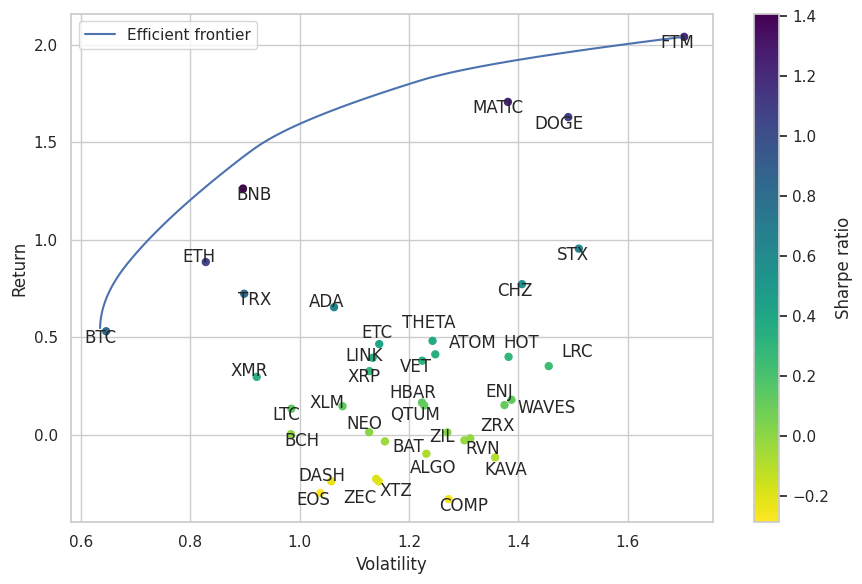

In [98]:
mu = expected_returns.mean_historical_return(
    returns, returns_data=True, frequency=FREQUENCY
)

cov = risk_models.CovarianceShrinkage(
    returns, returns_data=True, frequency=FREQUENCY
).ledoit_wolf()


# Here we can control the maximum percentage per one asset
ef = EfficientFrontier(
    mu,
    cov,
    weight_bounds=(0, 1),
    solver="OSQP",
    solver_options={"eps_abs": 1e-6},
)


set_style((9, 6))
fig, ax = plt.subplots()
ret_range = np.linspace(0, 10, 100)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Plot assets
# cov = risk_models.sample_cov(returns, returns_data=True, frequency=FREQUENCY)
asset_sigma = np.sqrt(np.diag(cov))
rets = np.array(mu)
sharpes = rets / asset_sigma
heatmap = ax.scatter(asset_sigma, rets, marker=".", s=100, c=sharpes, cmap="viridis_r")
cbar = plt.colorbar(heatmap)
cbar.set_label("Sharpe ratio")

# Output
# ax.set_title("Efficient frontier for selected assets")
ax.legend()
plt.tight_layout()

texts = [ax.text(asset_sigma[i], rets[i], label) for i, label in enumerate(ef.tickers)]
from adjustText import adjust_text
adjust_text(texts)


plt.savefig("../images/ef_scatter.pdf", dpi=200)
plt.show()

## Portfolio Optimization


In [99]:
import cvxpy

print(cvxpy.installed_solvers())

['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


In [135]:
def get_portfolio_volatility(portfolio, returns, max_percentage=1):
    portfolio = {**portfolio, **{k: 0 for k in returns.columns if k not in portfolio}}

    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(
        returns, returns_data=True, frequency=FREQUENCY
    )
    # cov = risk_models.sample_cov(returns, returns_data=True, frequency=frequency)
    cov = risk_models.CovarianceShrinkage(
        returns, returns_data=True, frequency=FREQUENCY
    ).ledoit_wolf()

    # Here we can control the maximum percentage per one asset
    ef = EfficientFrontier(
        mu,
        cov,
        weight_bounds=(0, max_percentage),
        solver="SCS",
        solver_options={"eps_abs": 1e-10},
    )

    ef.set_weights(portfolio)
    p = ef.portfolio_performance(verbose=True)
    volatility = p[1]

    # solver="OSQP"
    es = EfficientSemivariance(
        mu,
        returns,
        frequency=FREQUENCY,
        weight_bounds=(0, max_percentage),
        solver="OSQP",
        solver_options={"eps_abs": 1e-6, "max_iter": 20000},
        # verbose=True
    )
    es.set_weights(portfolio)
    p = es.portfolio_performance(verbose=True)
    semideviation = p[1]
    return volatility, semideviation

# p = min_volatility_portfolio(returns)
# get_portfolio_volatility(p, returns)

In [124]:
def min_volatility_portfolio(returns, max_percentage=1):
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(
        returns, returns_data=True, frequency=FREQUENCY
    )
    # cov = risk_models.sample_cov(returns, returns_data=True, frequency=frequency)
    cov = risk_models.CovarianceShrinkage(
        returns, returns_data=True, frequency=FREQUENCY
    ).ledoit_wolf()

    # Here we can control the maximum percentage per one asset
    ef = EfficientFrontier(
        mu,
        cov,
        weight_bounds=(0, max_percentage),
        solver="SCS",
        solver_options={"eps_abs": 1e-10},
    )
    _ = ef.min_volatility()
    cleaned_weights = ef.clean_weights()
    portfolio = {k: v for k, v in cleaned_weights.items() if v > 0}
    print(portfolio)

    ef.portfolio_performance(verbose=True)

    return portfolio

In [107]:
_ = min_volatility_portfolio(returns[["BTC", "ETH"]])
dai_columns = ['BAT', 'LINK', 'MATIC', 'ZRX', 'ETH', 'BTC']
for i in range(0, len(returns), 100 * DAILY_FREQUENCY):
    _ = min_volatility_portfolio(returns[dai_columns].iloc[i:])

here
{'BTC': 1.0}
Expected annual return: 0.0%
Annual volatility: 64.5%
Sharpe Ratio: -0.03
here
{'BTC': 1.0}
Expected annual return: 0.0%
Annual volatility: 64.6%
Sharpe Ratio: -0.03
here
{'BTC': 1.0}
Expected annual return: 0.0%
Annual volatility: 66.0%
Sharpe Ratio: -0.03
here
{'BTC': 1.0}
Expected annual return: 0.0%
Annual volatility: 65.4%
Sharpe Ratio: -0.03
here
{'BTC': 1.0}
Expected annual return: 0.0%
Annual volatility: 61.4%
Sharpe Ratio: -0.03
here
{'BTC': 1.0}
Expected annual return: 0.0%
Annual volatility: 56.0%
Sharpe Ratio: -0.04
here
{'BTC': 1.0}
Expected annual return: 0.0%
Annual volatility: 54.9%
Sharpe Ratio: -0.04
here
{'BTC': 1.0}
Expected annual return: 0.0%
Annual volatility: 53.3%
Sharpe Ratio: -0.04
here
{'BTC': 0.99999}
Expected annual return: 0.0%
Annual volatility: 50.6%
Sharpe Ratio: -0.04
here
{'ETH': 0.02642, 'BTC': 0.97359}
Expected annual return: 0.0%
Annual volatility: 45.6%
Sharpe Ratio: -0.04
here
{'ETH': 0.25169, 'BTC': 0.74832}
Expected annual re

In [10]:
def min_cvar_portfolio(returns, max_percentage=1):
    # Calculate expected returns
    mu = expected_returns.mean_historical_return(
        returns, returns_data=True, frequency=FREQUENCY
    )

    # solver="OSQP"
    es = EfficientCVaR(
        mu,
        returns,
        beta=0.75,
        weight_bounds=(0, max_percentage),
        solver="OSQP",
        solver_options={"eps_abs": 1e-10},
    )
    _ = es.min_cvar()
    cleaned_weights = es.clean_weights()
    portfolio = {k: v for k, v in cleaned_weights.items() if v > 0}
    print(portfolio)

    es.portfolio_performance(verbose=True)

    return portfolio

In [140]:
_ = min_cvar_portfolio(returns[["BTC", "ETH"]])
_ = min_cvar_portfolio(returns)

{'BTC': 1.0}
Expected annual return: 51.6%
Conditional Value at Risk: 0.74%
{'BTC': 0.92698, 'TRX': 0.0655, 'XMR': 0.00753}
Expected annual return: 52.0%
Conditional Value at Risk: 0.74%


In [20]:
def min_semivariance_portfolio(returns, min_percentage=0, max_percentage=1):
    # Calculate expected returns
    mu = expected_returns.mean_historical_return(
        returns, returns_data=True, frequency=FREQUENCY
    )
    # mu *= 0

    # solver="OSQP"
    es = EfficientSemivariance(
        mu,
        returns,
        frequency=FREQUENCY,
        weight_bounds=(min_percentage, max_percentage),
        solver="OSQP",
        solver_options={"eps_abs": 1e-6, "max_iter": 20000},
        # verbose=True
    )
    _ = es.min_semivariance()
    cleaned_weights = es.clean_weights()
    portfolio = {k: v for k, v in cleaned_weights.items() if v > 0}
    print(portfolio)

    es.portfolio_performance(verbose=True)

    return portfolio

In [142]:
_ = min_semivariance_portfolio(returns[["BTC", "ETH"]])
_ = min_semivariance_portfolio(returns)

{'BTC': 1.0}
Expected annual return: 51.6%
Annual semi-deviation: 48.4%
Sortino Ratio: 1.02
{'BTC': 0.92964, 'TRX': 0.07036}
Expected annual return: 52.2%
Annual semi-deviation: 48.3%
Sortino Ratio: 1.04


In [143]:
def plot_portfolios(portfolios, save_name=None):
    set_style((9, 6))

    columns = sorted(set(k for p in portfolios.values() for k in p.keys()), key=lambda x: -portfolios["min-volatility"].get(x, 0))
    data_dict = {}
    for key, p in portfolios.items():
        data_dict[key] = [p.get(col, 0) for col in columns]

    pf_df = pd.DataFrame.from_dict(data_dict, orient="index", columns=columns)
    pf_df = pf_df.reset_index().melt("index").rename(columns={"variable": "Token", "value": "Partition", "index": "Portfolio"})
    pf_df["Token"] = pf_df["Token"].map(symbol_to_name.get)
    sns.barplot(pf_df, x="Token", y="Partition", hue="Portfolio")
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    if save_name is not None:
        plt.savefig(f"../images/{save_name}.pdf", bbox_inches='tight')

    plt.show()


In [144]:
portfolios = {}
portfolios["min-semivariance"] = min_semivariance_portfolio(returns, max_percentage=1)
portfolios["min-volatility"] = min_volatility_portfolio(returns, max_percentage=1)
portfolios["min-cvar"] = min_cvar_portfolio(returns, max_percentage=1)

{'BTC': 0.92964, 'TRX': 0.07036}
Expected annual return: 52.2%
Annual semi-deviation: 48.3%
Sortino Ratio: 1.04
here
{'BTC': 0.82015, 'TRX': 0.12957, 'XMR': 0.05033}
Expected annual return: 51.5%
Annual volatility: 67.2%
Sharpe Ratio: 0.74
{'BTC': 0.92698, 'TRX': 0.0655, 'XMR': 0.00753}
Expected annual return: 52.0%
Conditional Value at Risk: 0.74%


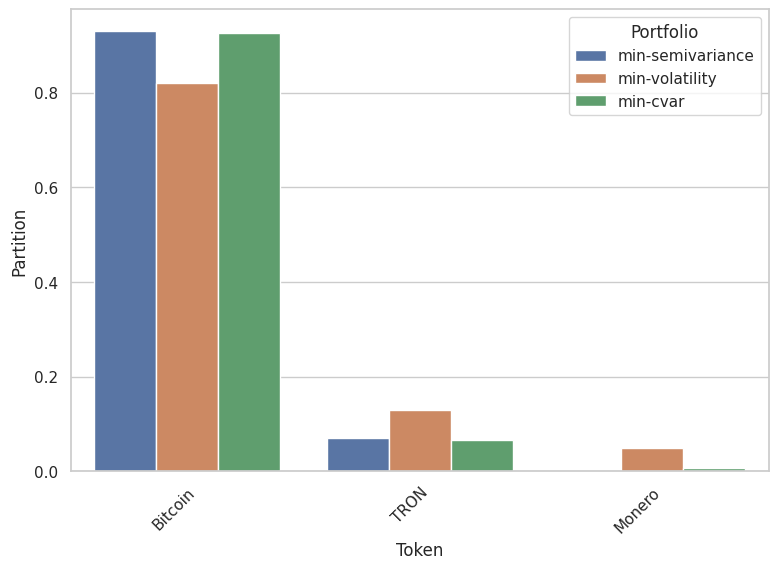

In [145]:
plot_portfolios(portfolios, "portfolios_100")

In [146]:
portfolios20 = {}
portfolios20["min-semivariance"] = min_semivariance_portfolio(returns, max_percentage=0.2)
portfolios20["min-volatility"] = min_volatility_portfolio(returns, max_percentage=0.2)
portfolios20["min-cvar"] = min_cvar_portfolio(returns, max_percentage=0.2)


{'BTC': 0.2, 'ETH': 0.2, 'BNB': 0.1955, 'DOGE': 0.01912, 'TRX': 0.2, 'XMR': 0.18538}
Expected annual return: 68.5%
Annual semi-deviation: 54.5%
Sortino Ratio: 1.22
here
{'BTC': 0.2, 'ETH': 0.19361, 'BNB': 0.1639, 'XRP': 0.02125, 'DOGE': 0.03247, 'TRX': 0.2, 'XMR': 0.18879}
Expected annual return: 67.0%
Annual volatility: 73.3%
Sharpe Ratio: 0.89
{'BTC': 0.2, 'ETH': 0.1762, 'BNB': 0.2, 'XRP': 0.01509, 'DOGE': 0.02995, 'TRX': 0.2, 'XMR': 0.17876}
Expected annual return: 68.3%
Conditional Value at Risk: 0.83%


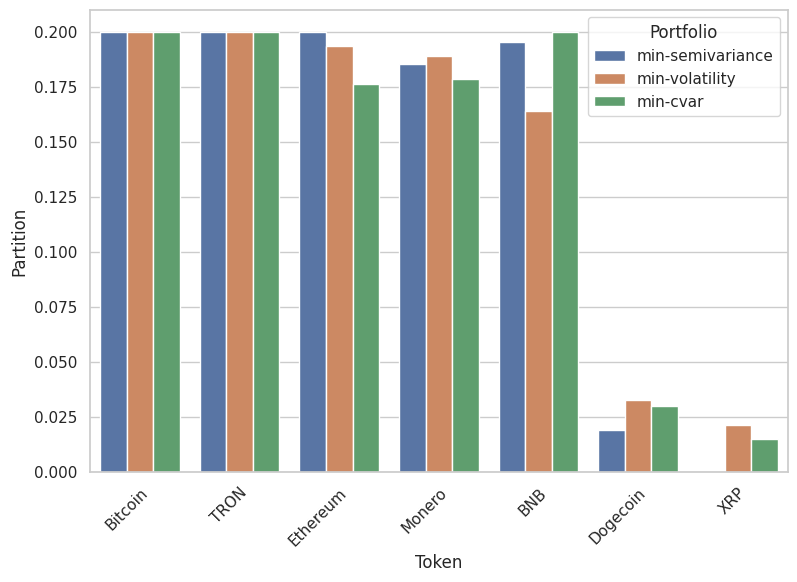

In [147]:
plot_portfolios(portfolios20, "portfolios_20")

{'BTC': 0.1, 'ETH': 0.1, 'BNB': 0.1, 'XRP': 0.1, 'ADA': 0.05895, 'DOGE': 0.08726, 'TRX': 0.1, 'LTC': 0.07596, 'XMR': 0.1, 'XLM': 0.04457, 'BCH': 0.1, 'HBAR': 0.00285, 'STX': 0.01631, 'HOT': 0.01411}
Expected annual return: 55.4%
Annual semi-deviation: 58.5%
Sortino Ratio: 0.91
here
{'BTC': 0.1, 'ETH': 0.1, 'BNB': 0.1, 'XRP': 0.09359, 'ADA': 0.01729, 'DOGE': 0.06896, 'TRX': 0.1, 'LTC': 0.07314, 'XMR': 0.1, 'XLM': 0.06602, 'BCH': 0.1, 'HBAR': 0.02319, 'STX': 0.03228, 'HOT': 0.02554}
Expected annual return: 51.8%
Annual volatility: 78.1%
Sharpe Ratio: 0.64
{'BTC': 0.1, 'ETH': 0.1, 'BNB': 0.1, 'XRP': 0.1, 'DOGE': 0.09939, 'TRX': 0.1, 'LTC': 0.07284, 'XMR': 0.1, 'XLM': 0.06881, 'BCH': 0.1, 'HBAR': 0.01811, 'STX': 0.0161, 'HOT': 0.02474}
Expected annual return: 53.1%
Conditional Value at Risk: 0.89%


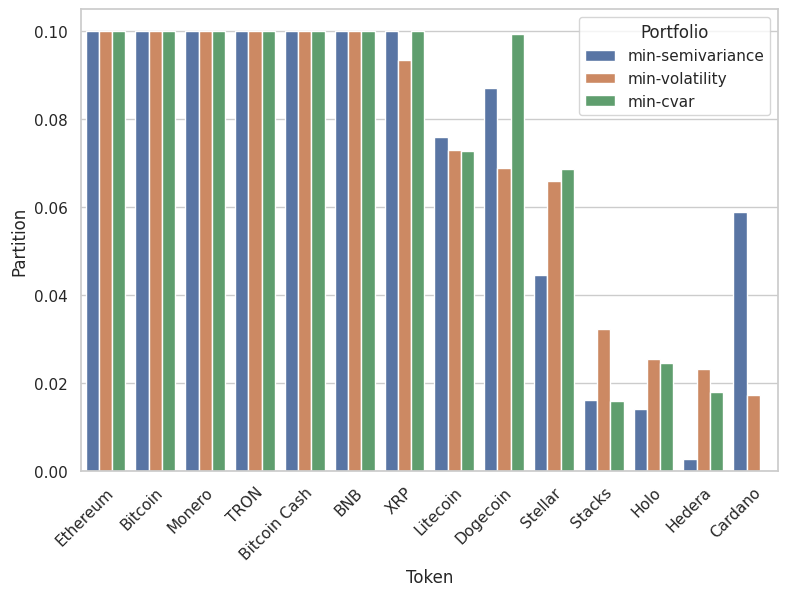

In [148]:
portfolios10 = {}
portfolios10["min-semivariance"] = min_semivariance_portfolio(returns, max_percentage=0.1)
portfolios10["min-volatility"] = min_volatility_portfolio(returns, max_percentage=0.1)
portfolios10["min-cvar"] = min_cvar_portfolio(returns, max_percentage=0.1)

plot_portfolios(portfolios10, "portfolios_10")

## Following simulations are using above defined portfolio


# Notes

We can define new variable $\gamma$ representing initial overcollaterization (ratio between collected value and value of issued stable coin). We can write:

$$
\gamma = \frac{\sum_j \alpha_j p_j(0)}{x},
$$

where $x$ is amount of issued stablecoins, $p_j(0)$ and $\alpha_j$ is the initial price and amount of token $j$.
Deriving the formula for $x$ and substituting it into the original condition of expected overcolaterization.
\begin{aligned}
x &= \frac{\sum_j \alpha_j p_j(0)}{\gamma} \\
\sum_j \alpha_j p_j(t) &\leq \frac{\sum_j \alpha_j p_j(0)}{\gamma} \theta \\
\left(\frac{\text{Current value}}{\text{Initial value}}=\right) \frac{\sum_j \alpha_j p_j(t)}{\sum_j \alpha_j p_j(0)}&\leq \frac{\theta}{\gamma}
\end{aligned}
Therefore the condition doesn't depend on absolute value of portfolio. We can scale all $\alpha_j$ by any constant other than 0 without affecting the condition.

<span style="color: red;">Consider minimum variance portfolio - trading for minimum variance</span>


### Assuming that we have fixed proportion of asset in portfolio


In [11]:
def sem(values):
    """Calculate standard error of mean."""
    return np.std(values, ddof=1) / np.sqrt(np.size(values))


class Simulation:
    name = "Simulation GBM"

    def __init__(
        self, returns, portfolio, initial_overcol, expected_overcol, time_block
    ):
        """Initialize simulation object with given portfolio defined by values.

        Args:
            returns: dataframe with log returns for different tokens
            portfolio: portfolio defined as mapping of token to percentage in portfolio
            initial_overcol: value of initial overcollaterization
            expected_overcol: value of expected overcollaterization
            time_block: size of historical time block to use for the simulation
        """
        self.returns = returns
        self.portfolio = portfolio
        self.initial_value = sum(portfolio.values()) * initial_overcol
        self.expected_overcol = expected_overcol

        self.update_initial_overcol(initial_overcol)

        self._symbols = list(portfolio.keys())
        self._v = np.array(list(portfolio.values())) * initial_overcol

        self.time_block = time_block
        self.volatility = self._get_volatility()
        self.means = self._get_mean()

        self.periods = len(self.means)

        print(f"Periods: {self.periods}")
        print(f"Mean: {self.means}")
        print(f"Vol: {self.volatility}")

    def update_initial_overcol(self, initial_overcol):
        """Update value of initial over-collaterization."""
        self.initial_overcol = initial_overcol
        self.critical_value = (
            self.initial_value * self.expected_overcol / self.initial_overcol
        )

    @property
    def _block_iter(self):
        # Get 25 evenly separated blocks
        step_size = (len(self.returns) - self.time_block) // 50
        return range(0, len(self.returns) - self.time_block, step_size)

    def _get_volatility(self):
        """Calculate volatility of portfolio given by values."""
        vols = []
        for i in self._block_iter:
            cov = self.returns.iloc[i : i + self.time_block][self._symbols].cov()
            vols.append(((self._v @ cov @ self._v.T) ** 0.5) / self._v.sum())
        return vols

    def _get_mean(self):
        """Calculate mean of portfolio given by values."""
        means = []
        for i in self._block_iter:
            mean = (
                self.returns[self._symbols].values[i : i + self.time_block].mean(axis=0)
            )
            means.append(self._v @ mean)
        return means

    def _check_condition(self, values):
        """Check if the condtion for expected overcolaterization was broken at some point."""
        return any(values <= self.critical_value)

    def _returns_simulation(self, steps, period=0):
        dt = 1
        mean = self.means[period]
        volatility = self.volatility[period]

        returns = (
            (mean - volatility**2 / 2) * dt
            + volatility * np.random.normal(0, np.sqrt(dt), size=(steps, 1))
        )
        return np.vstack([[0], returns])

    def value_simulation(self, steps, period=0):
        """Simulate one value (price) path using GBM based on mu and sigma."""
        returns = self._returns_simulation(steps, period)
        values = self.initial_value * np.exp(returns.cumsum(axis=0))
        return values

    def simulate(self, sim_days, runs, log=True):
        """Run the simulation and calculate the percentage of failures.

        Args:
            sim_days: number of days to simulate
            runs: number of runs of the simulation
            log: print final results if true
        """
        n_steps = int(sim_days * 24 * 60 / 5)

        stats = []
        for i in range(runs):
            period = i % self.periods
            values = self.value_simulation(n_steps, period)
            failed = self._check_condition(values)
            stats.append(failed)

        stats = np.array(stats)
        if log:
            print(f"{stats.mean()} +- {sem(stats)}")
        return stats, stats.mean()

    def plot_simulations(self, sim_days):
        set_style((10, 7))

        n_steps = int(sim_days * DAILY_FREQUENCY)
        x_values = [i / 24 for i in range(n_steps + 1)]
        # Visualisation
        for x in range(3):
            values = self.value_simulation(n_steps, x % self.periods)
            plt.plot(x_values, values)

        plt.axhline(y=self.critical_value, color="r", linestyle="--")
        # plt.text(
        #     0,
        #     self.critical_value,
        #     f"{self.critical_value:.1f}",
        #     color="r",
        #     # transform=transform,
        #     ha="right",
        #     va="center",
        #     fontsize=10,
        # )

        plt.xlabel("Time (days)")
        plt.ylabel("Over-collateralization ratio")
        plt.xlim((0, max(x_values)))
        plt.savefig(f"../images/simulations/{self.name}.pdf", bbox_inches='tight')
        plt.show()

In [12]:
# portfolio = {"BTC": 0.5, "ETH": 0.5}
portfolio = min_semivariance_portfolio(returns, max_percentage=0.1)

# Parameters:
sim_days = 365
initial_overcol = 2.0
expected_overcol = 1.5
# How many days of historical data to use for simulation
time_block = int(100 * DAILY_FREQUENCY)

NameError: name 'min_semivariance_portfolio' is not defined

In [15]:
sim = Simulation(log_returns, portfolio, initial_overcol, expected_overcol, time_block)

# Simulation (for T=1 day, 100000 runs)
_ = sim.simulate(sim_days, 1000)

Periods: 51
Mean: [0.0001925743572710293, 1.8537399576931176e-05, 7.532913715414195e-05, -0.00014490873749121465, 0.0003039578239693806, 0.0003212370386351654, 0.00032712955143530156, 0.00015004274125450135, 0.000163135194432163, 6.12184136941956e-05, 0.00045165737445429104, 0.0006933128210324671, 0.001165658389835272, 0.0008948252647623552, 0.0011606448553489579, 0.0012901849169663084, 0.0004052076267519539, 0.00011648078722416607, -0.00022720390838410889, 0.0001426446121268697, 8.246124086007079e-05, 0.0004399335143903846, -2.5280400692633277e-05, -0.00010112587748425373, -0.00020681475147939557, -0.000513764618289362, -0.0002758779852691578, -9.378157928126235e-05, -0.0002270401246603803, -0.00036204830381570915, -0.0006277292838667576, -0.0003483254819690041, -0.0001671314491719896, 5.508488272734157e-06, 6.0658026778450274e-05, -5.922842987490599e-05, -5.6547209101975676e-05, 9.901028655516584e-05, 0.00018695761820909247, 0.0001513679884998454, 0.00017373869143717186, -1.233952317

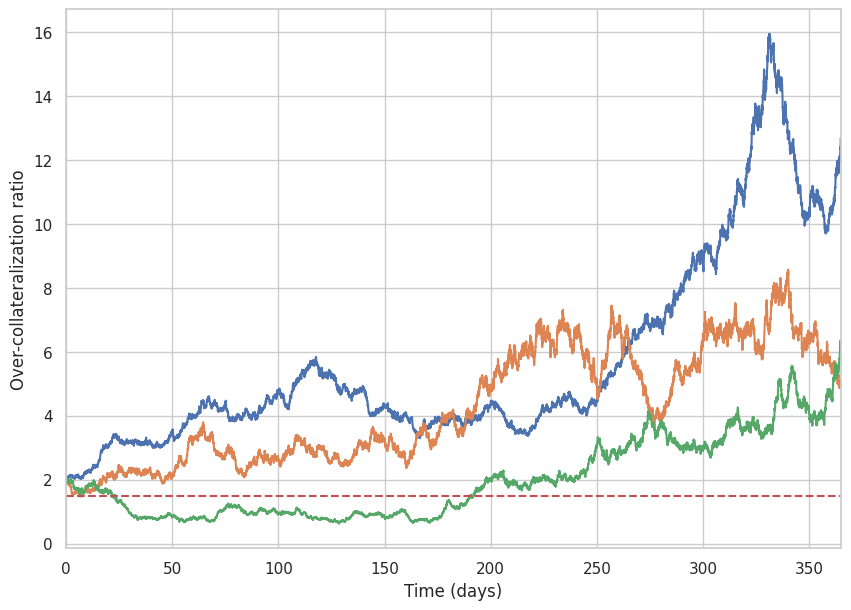

In [16]:
sim.plot_simulations(sim_days)

### GMB for each asset separately


In [16]:
# https://scipy-cookbook.readthedocs.io/items/CorrelatedRandomSamples.html


class SimulationPrices(Simulation):
    """Simulation class simulating prices separately for each asset in portfolio."""
    name = "Simulation Individual Prices"

    def __init__(
        self, returns, portfolio, initial_overcol, expected_overcol, time_block
    ):
        """Initialize simulation object with given portfolio defined by weights.

        Args:
            returns: dataframe with log returns for different tokens
            portfolio: portfolio defined as mapping of token to percentage in portfolio
            initial_overcol: value of initial overcollaterization
            expected_overcol: value of expected overcollaterization
            time_block: size of historical time block to use for the simulation
        """
        super().__init__(
            returns, portfolio, initial_overcol, expected_overcol, time_block
        )

        self.means, self.volatility, self.chol_mats = [], [], []
        for i in self._block_iter:
            rets = self.returns.iloc[i : i + time_block - 1][self._symbols]
            self.means.append(rets.mean().values)
            self.volatility.append(rets.std().values)

            # Precalculate decomposition for speedup
            self.chol_mats.append(np.linalg.cholesky(rets.cov()))

    def _returns_simulation(self, steps, period=0):
        normals = np.random.normal(size=(len(self._symbols), steps))
        rand_vars = self.chol_mats[period] @ normals

        mean = self.means[period]
        volatility = self.volatility[period]

        dt = 1
        sim_returns = ((mean - volatility**2 / 2) * dt + rand_vars.T)

        return np.vstack([np.zeros((len(self._symbols),)), sim_returns])

    def value_simulation(self, steps, period=0):
        """Simulate prices for each asset separately."""
        # Generate random normal values with same covariance as covariance of original returns
        sim_returns = self._returns_simulation(steps, period)
        values = (self._v * np.exp(sim_returns.cumsum(axis=0))).sum(axis=1)
        return values

In [46]:
sim2 = SimulationPrices(
    log_returns, portfolio, initial_overcol, expected_overcol, time_block
)

mean = sim2.simulate(sim_days, 1000)

Periods: 51
Mean: [0.0001925743572710293, 1.8537399576931176e-05, 7.532913715414195e-05, -0.00014490873749121465, 0.0003039578239693806, 0.0003212370386351654, 0.00032712955143530156, 0.00015004274125450135, 0.000163135194432163, 6.12184136941956e-05, 0.00045165737445429104, 0.0006933128210324671, 0.001165658389835272, 0.0008948252647623552, 0.0011606448553489579, 0.0012901849169663084, 0.0004052076267519539, 0.00011648078722416607, -0.00022720390838410889, 0.0001426446121268697, 8.246124086007079e-05, 0.0004399335143903846, -2.5280400692633277e-05, -0.00010112587748425373, -0.00020681475147939557, -0.000513764618289362, -0.0002758779852691578, -9.378157928126235e-05, -0.0002270401246603803, -0.00036204830381570915, -0.0006277292838667576, -0.0003483254819690041, -0.0001671314491719896, 5.508488272734157e-06, 6.0658026778450274e-05, -5.922842987490599e-05, -5.6547209101975676e-05, 9.901028655516584e-05, 0.00018695761820909247, 0.0001513679884998454, 0.00017373869143717186, -1.233952317

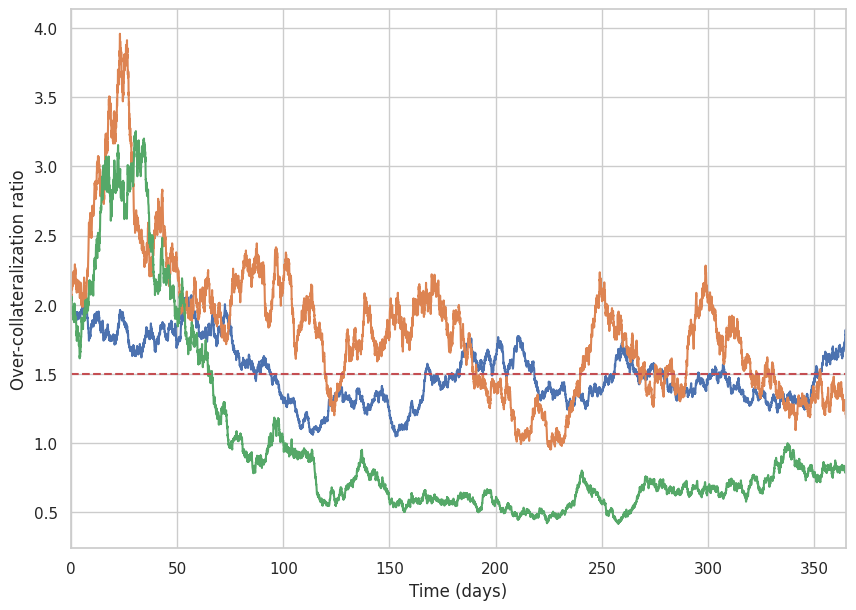

In [25]:
sim2.plot_simulations(sim_days)

In [17]:
class SimulationPricesRebalance(SimulationPrices):
    """Simulation class simulating prices separately for each asset in portfolio."""
    name = "Simulation Individual Prices - Rebalance"

    def value_simulation(self, steps, period=0):
        """Simulate prices for each asset separately."""
        # Generate random normal values with same covariance as covariance of original returns
        sim_returns = self._returns_simulation(steps, period)

        values = np.array([np.sum(self._v)])
        ratios = self._v / np.sum(self._v)

        step = DAILY_FREQUENCY * 10
        for i in range(1, len(sim_returns), step):
            _v = ratios * values[-1]
            vals = (_v * np.exp(sim_returns[i:i+step].cumsum(axis=0))).sum(axis=1)
            values = np.append(values, vals)
        
        values1 = (self._v * np.exp(sim_returns.cumsum(axis=0))).sum(axis=1)
        print(values1 - values)

        return values

In [57]:
sim2 = SimulationPricesRebalance(
    log_returns, portfolio, initial_overcol, expected_overcol, time_block
)
_ = sim2.value_simulation(sim_days)

Periods: 51
Mean: [0.0001925743572710293, 1.8537399576931176e-05, 7.532913715414195e-05, -0.00014490873749121465, 0.0003039578239693806, 0.0003212370386351654, 0.00032712955143530156, 0.00015004274125450135, 0.000163135194432163, 6.12184136941956e-05, 0.00045165737445429104, 0.0006933128210324671, 0.001165658389835272, 0.0008948252647623552, 0.0011606448553489579, 0.0012901849169663084, 0.0004052076267519539, 0.00011648078722416607, -0.00022720390838410889, 0.0001426446121268697, 8.246124086007079e-05, 0.0004399335143903846, -2.5280400692633277e-05, -0.00010112587748425373, -0.00020681475147939557, -0.000513764618289362, -0.0002758779852691578, -9.378157928126235e-05, -0.0002270401246603803, -0.00036204830381570915, -0.0006277292838667576, -0.0003483254819690041, -0.0001671314491719896, 5.508488272734157e-06, 6.0658026778450274e-05, -5.922842987490599e-05, -5.6547209101975676e-05, 9.901028655516584e-05, 0.00018695761820909247, 0.0001513679884998454, 0.00017373869143717186, -1.233952317

Periods: 51
Mean: [0.0001925743572710293, 1.8537399576931176e-05, 7.532913715414195e-05, -0.00014490873749121465, 0.0003039578239693806, 0.0003212370386351654, 0.00032712955143530156, 0.00015004274125450135, 0.000163135194432163, 6.12184136941956e-05, 0.00045165737445429104, 0.0006933128210324671, 0.001165658389835272, 0.0008948252647623552, 0.0011606448553489579, 0.0012901849169663084, 0.0004052076267519539, 0.00011648078722416607, -0.00022720390838410889, 0.0001426446121268697, 8.246124086007079e-05, 0.0004399335143903846, -2.5280400692633277e-05, -0.00010112587748425373, -0.00020681475147939557, -0.000513764618289362, -0.0002758779852691578, -9.378157928126235e-05, -0.0002270401246603803, -0.00036204830381570915, -0.0006277292838667576, -0.0003483254819690041, -0.0001671314491719896, 5.508488272734157e-06, 6.0658026778450274e-05, -5.922842987490599e-05, -5.6547209101975676e-05, 9.901028655516584e-05, 0.00018695761820909247, 0.0001513679884998454, 0.00017373869143717186, -1.233952317

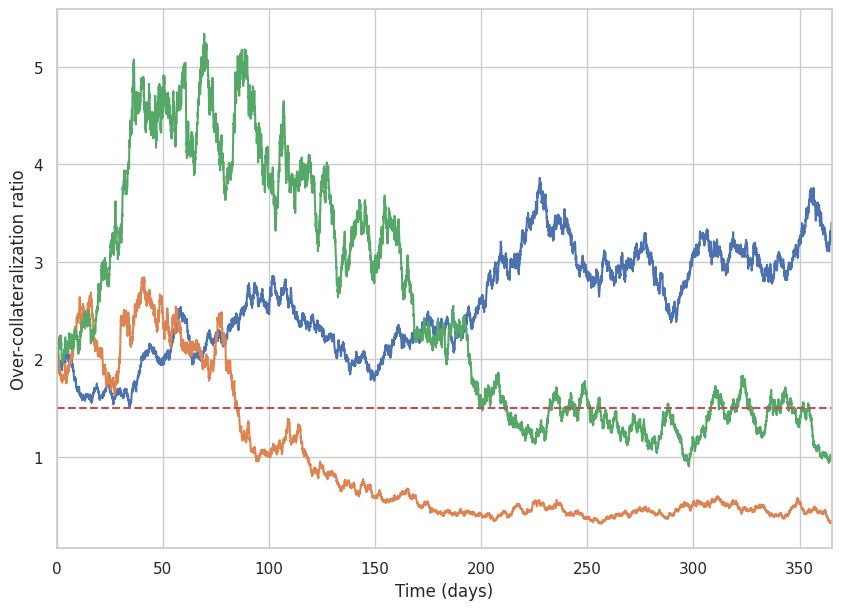

In [50]:
sim2 = SimulationPricesRebalance(
    log_returns, portfolio, initial_overcol, expected_overcol, time_block
)

sim2.simulate(sim_days, 1000)
sim2.plot_simulations(sim_days)

# t-Distribution GBM


In [32]:
def t_fit(X, dof=3.5, iter=200, eps=1e-6):
    """t estimate scale matrix of multivariate t-distribution.
    Code from: https://gist.github.com/cdipaolo/9dd6794a4f0a2889ef60a5effa419093
    Implementation based on the algorithm detailed in Murphy
    Section 11.4.5 (page 362).

    Args:
        X: dataset (n_samples, n_variables)
        dof: degrees of freedom for likelihood (>2)
        iter: maximum EM iterations
        eps: tolerance for EM convergence

    Returns:
        estimated covariance, estimated mean, list of objectives
    """
    # initialize parameters
    D = X.shape[1]
    N = X.shape[0]
    cov = np.cov(X, rowvar=False)
    mean = X.mean(axis=0)
    mu = X - mean[None, :]
    delta = np.einsum("ij,ij->i", mu, np.linalg.solve(cov, mu.T).T)
    z = (dof + D) / (dof + delta)
    obj = [
        -N * np.linalg.slogdet(cov)[1] / 2
        - (z * delta).sum() / 2
        - N * special.gammaln(dof / 2)
        + N * dof * np.log(dof / 2) / 2
        + dof * (np.log(z) - z).sum() / 2
    ]

    # iterate
    for i in range(iter):
        # M step
        mean = (X * z[:, None]).sum(axis=0).reshape(-1, 1) / z.sum()
        mu = X - mean.squeeze()[None, :]
        cov = np.einsum("ij,ik->jk", mu, mu * z[:, None]) / N

        # E step
        delta = (mu * np.linalg.solve(cov, mu.T).T).sum(axis=1)
        delta = np.einsum("ij,ij->i", mu, np.linalg.solve(cov, mu.T).T)
        z = (dof + D) / (dof + delta)

        # store objective
        obj.append(
            -N * np.linalg.slogdet(cov)[1] / 2
            - (z * delta).sum() / 2
            - N * special.gammaln(dof / 2)
            + N * dof * np.log(dof / 2) / 2
            + dof * (np.log(z) - z).sum() / 2
        )

        if np.abs(obj[-1] - obj[-2]) < eps:
            break
    return cov, mean.squeeze(), obj

In [33]:
class SimulationTPrices(Simulation):
    """Simulation class simulating prices separately for each asset in portfolio."""
    name = "Simulation t-Distribution"

    def __init__(
        self, returns, portfolio, initial_overcol, expected_overcol, time_block
    ):
        """Initialize simulation object with given portfolio defined by weights.

        Args:
            returns: dataframe with log returns for different tokens
            portfolio: portfolio defined as mapping of token to percentage in portfolio
            initial_overcol: value of initial overcollaterization
            expected_overcol: value of expected overcollaterization
            time_block: size of historical time block to use for the simulation
        """
        super().__init__(
            returns, portfolio, initial_overcol, expected_overcol, time_block
        )
        # returns = returns.clip(-0.2, 0.2)

        self.means, self.volatility, self.df, self.mats = [], [], [], []
        for i in self._block_iter:
            rets = self.returns[self._symbols].values[i : i + time_block]

            params = [t.fit(rets[:, s]) for s in range(len(self._symbols))]
            params = np.array(params).T

            dof = self.combined_dof(params[0])
            mat, means = None, params[1]
            if len(self._symbols) > 1:
                mat, means, _ = t_fit(rets, dof=dof, iter=1000)

            # Seems to give better values
            means = rets.mean(axis=0)

            self.df.append(params[0])
            self.means.append(means)
            self.volatility.append(params[2])
            self.mats.append(mat)

    def combined_dof(self, dofs):
        """Calculate combined dof for the multivariate_t."""
        # DOF must be bigger than 2
        return max(np.mean(dofs), 2.1)

    def _returns_simulation(self, steps, period=0):
        # Generate random normal values with same covariance as covariance of original returns
        if len(self._symbols) > 1:
            dof = self.combined_dof(self.df[period])
            random_vals = multivariate_t.rvs(
                np.zeros(self.means[period].shape),
                self.mats[period],
                dof,
                steps,
            )
        else:
            random_vals = t.rvs(
                self.df[period], self.means[period], self.volatility[period], steps
            )
            random_vals = np.expand_dims(random_vals, axis=-1)

        mean = self.means[period]
        volatility = self.volatility[period]

        # sim_returns = np.exp(random_vals)
        dt = 1
        sim_returns = (mean - volatility**2 / 2) * dt + random_vals
        return np.vstack([np.zeros((len(self._symbols),)), sim_returns])

    def value_simulation(self, steps, period=0):
        """Simulate prices for each asset separately."""
        sim_returns = self._returns_simulation(steps, period)
        values = (self._v * np.exp(sim_returns.cumsum(axis=0))).sum(axis=1)
        return values

In [34]:
sim3 = SimulationTPrices(
    log_returns, portfolio, initial_overcol, expected_overcol, time_block
)

mean = sim3.simulate(sim_days, 100)

Periods: 51
Mean: [0.0001925743572710293, 1.8537399576931176e-05, 7.532913715414195e-05, -0.00014490873749121465, 0.0003039578239693806, 0.0003212370386351654, 0.00032712955143530156, 0.00015004274125450135, 0.000163135194432163, 6.12184136941956e-05, 0.00045165737445429104, 0.0006933128210324671, 0.001165658389835272, 0.0008948252647623552, 0.0011606448553489579, 0.0012901849169663084, 0.0004052076267519539, 0.00011648078722416607, -0.00022720390838410889, 0.0001426446121268697, 8.246124086007079e-05, 0.0004399335143903846, -2.5280400692633277e-05, -0.00010112587748425373, -0.00020681475147939557, -0.000513764618289362, -0.0002758779852691578, -9.378157928126235e-05, -0.0002270401246603803, -0.00036204830381570915, -0.0006277292838667576, -0.0003483254819690041, -0.0001671314491719896, 5.508488272734157e-06, 6.0658026778450274e-05, -5.922842987490599e-05, -5.6547209101975676e-05, 9.901028655516584e-05, 0.00018695761820909247, 0.0001513679884998454, 0.00017373869143717186, -1.233952317

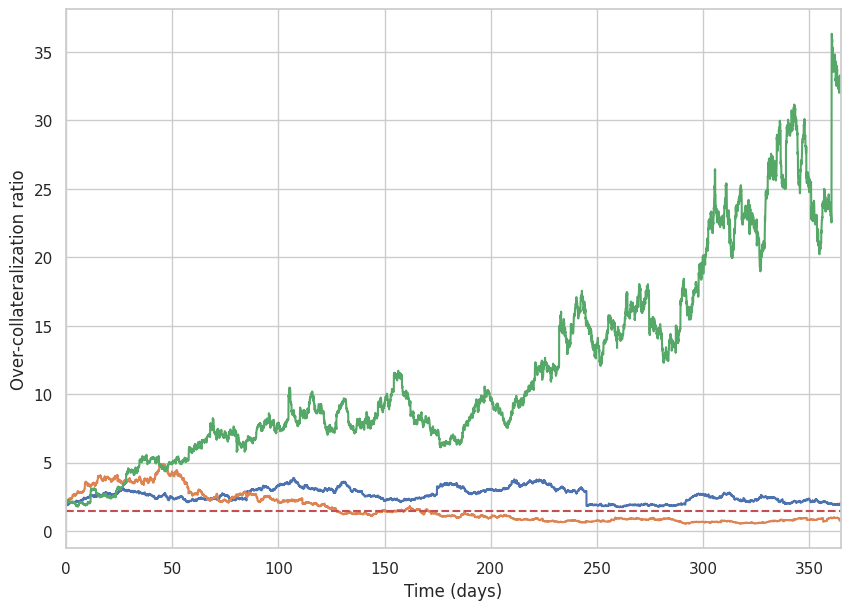

In [35]:
sim3.plot_simulations(sim_days)

In [36]:
class SimulationTPricesRebalance(SimulationTPrices):
    """Simulation class simulating prices separately for each asset in portfolio."""
    name = "Simulation T Prices - Rebalance"

    def value_simulation(self, steps, period=0):
        """Simulate prices for each asset separately."""
        # Generate random normal values with same covariance as covariance of original returns
        sim_returns = self._returns_simulation(steps, period)

        values = np.array([np.sum(self._v)])
        ratios = self._v / np.sum(self._v)

        for i in range(1, len(sim_returns), DAILY_FREQUENCY):
            _v = ratios * values[-1]
            vals = (_v * np.exp(sim_returns[i:i+DAILY_FREQUENCY].cumsum(axis=0))).sum(axis=1)
            values = np.append(values, vals)
        return values

Periods: 51
Mean: [0.0001925743572710293, 1.8537399576931176e-05, 7.532913715414195e-05, -0.00014490873749121465, 0.0003039578239693806, 0.0003212370386351654, 0.00032712955143530156, 0.00015004274125450135, 0.000163135194432163, 6.12184136941956e-05, 0.00045165737445429104, 0.0006933128210324671, 0.001165658389835272, 0.0008948252647623552, 0.0011606448553489579, 0.0012901849169663084, 0.0004052076267519539, 0.00011648078722416607, -0.00022720390838410889, 0.0001426446121268697, 8.246124086007079e-05, 0.0004399335143903846, -2.5280400692633277e-05, -0.00010112587748425373, -0.00020681475147939557, -0.000513764618289362, -0.0002758779852691578, -9.378157928126235e-05, -0.0002270401246603803, -0.00036204830381570915, -0.0006277292838667576, -0.0003483254819690041, -0.0001671314491719896, 5.508488272734157e-06, 6.0658026778450274e-05, -5.922842987490599e-05, -5.6547209101975676e-05, 9.901028655516584e-05, 0.00018695761820909247, 0.0001513679884998454, 0.00017373869143717186, -1.233952317

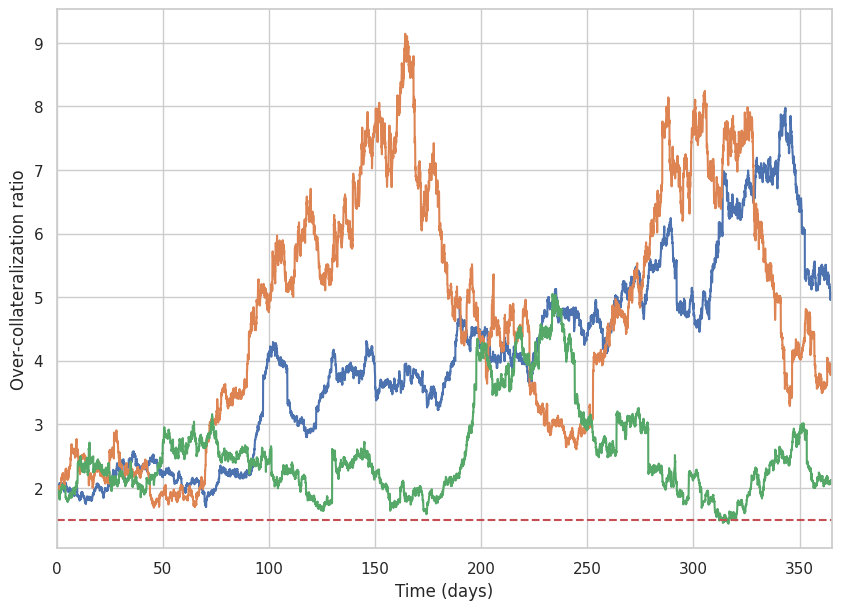

In [37]:
sim3 = SimulationTPricesRebalance(
    log_returns, portfolio, initial_overcol, expected_overcol, time_block
)

mean = sim3.simulate(sim_days, 100)
sim3.plot_simulations(sim_days)

# Historical Simulation

Estimating values using historical data and iterating over them


In [13]:
class HistoricalSimulation(Simulation):
    name = "Historical Prices"

    def _returns_simulation(self, steps, period=None, start=0):
        if period is not None:
            start = list(self._block_iter)[(period * 7) % len(self._block_iter)]
        returns = self.returns[self._symbols].values[start : start + steps]
        return np.vstack([np.zeros((len(self._symbols),)), returns])

    def value_simulation(self, steps, period=None, start=0):
        """Simulate one value (price) path using GBM based on mu and sigma."""
        returns = self._returns_simulation(steps, period, start)
        return (self._v * np.exp(returns.cumsum(axis=0))).sum(axis=1)

    def simulate(self, sim_days, runs, log=True, interest=0.05):
        """Run the simulation and calculate the percentage of failures.

        Args:
            sim_days: number of days to simulate
            runs: number of runs of the simulation (unused, for compatibility)
            log: print final results if true
        """
        n_steps = int(sim_days * DAILY_FREQUENCY)

        stats = []
        # Use step of 10 to make it bit faster (not changing results much)
        for i in range(0, max(0, len(self.returns) - n_steps) + 1, 10):
            values = self.value_simulation(n_steps, start=i)
            failed = self._check_condition(values)
            stats.append(failed)

        stats = np.array(stats)
        if log:
            print(f"{stats.mean()} +- {sem(stats)}")
        return stats, stats.mean()

In [18]:
sim3 = HistoricalSimulation(
    log_returns, portfolio, initial_overcol, expected_overcol, time_block
)

mean = sim3.simulate(sim_days, 100, interest=0)
mean = sim3.simulate(sim_days, 100, interest=0.05)
mean = sim3.simulate(sim_days, 100, interest=0.20)

Periods: 51
Mean: [0.0001925743572710293, 1.8537399576931176e-05, 7.532913715414195e-05, -0.00014490873749121465, 0.0003039578239693806, 0.0003212370386351654, 0.00032712955143530156, 0.00015004274125450135, 0.000163135194432163, 6.12184136941956e-05, 0.00045165737445429104, 0.0006933128210324671, 0.001165658389835272, 0.0008948252647623552, 0.0011606448553489579, 0.0012901849169663084, 0.0004052076267519539, 0.00011648078722416607, -0.00022720390838410889, 0.0001426446121268697, 8.246124086007079e-05, 0.0004399335143903846, -2.5280400692633277e-05, -0.00010112587748425373, -0.00020681475147939557, -0.000513764618289362, -0.0002758779852691578, -9.378157928126235e-05, -0.0002270401246603803, -0.00036204830381570915, -0.0006277292838667576, -0.0003483254819690041, -0.0001671314491719896, 5.508488272734157e-06, 6.0658026778450274e-05, -5.922842987490599e-05, -5.6547209101975676e-05, 9.901028655516584e-05, 0.00018695761820909247, 0.0001513679884998454, 0.00017373869143717186, -1.233952317

ValueError: x and y must have same first dimension, but have shapes (8761,) and (8762,)

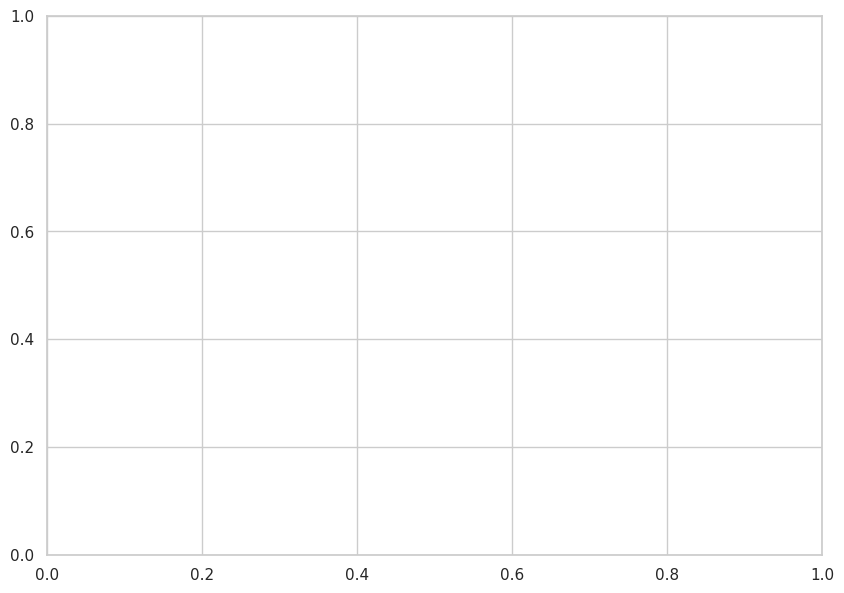

In [19]:
sim3.plot_simulations(sim_days)

In [49]:
class HistoricalSimulationRebalance(HistoricalSimulation):
    """Simulation class simulating prices separately for each asset in portfolio."""
    name = "Historical Simulation - Rebalance"

    def value_simulation(self, steps, period=None, start=0):
        """Simulate prices for each asset separately."""
        # Generate random normal values with same covariance as covariance of original returns
        sim_returns = self._returns_simulation(steps, period, start)

        values = np.array([np.sum(self._v)])
        ratios = self._v / np.sum(self._v)

        for i in range(1, len(sim_returns), DAILY_FREQUENCY):
            _v = ratios * values[-1]
            vals = (_v * np.exp(sim_returns[i:i+DAILY_FREQUENCY].cumsum(axis=0))).sum(axis=1)
            values = np.append(values, vals)
        return values

In [51]:
sim3 = HistoricalSimulationRebalance(
    log_returns, portfolio, initial_overcol, expected_overcol, time_block
)

mean = sim3.simulate(sim_days, 100)
sim3.plot_simulations(sim_days)

NameError: name 'portfolio' is not defined

## Testing different portfolios


In [141]:
def test_porfolios(simulator_classes):
    if type(simulator_classes) != list:
        simulator_classes = [simulator_classes]
    blockchains = log_returns.columns
    sim_days = 365
    initial_overcol = 2
    expected_overcol = 1.5
    # How many days of historical data to use for simulation
    time_block = int(100 * DAILY_FREQUENCY)

    optimization_methods = {
        "Min-Volatility": min_volatility_portfolio,
        "Min-Semivariance": min_semivariance_portfolio,
        # "Min-CVaR": min_cvar_portfolio,
    }

    # portfolios = {f"All {k} 100": fun(returns[blockchains], max_percentage=1) for k, fun in optimization_methods.items()}
    portfolios = {f"All {k} 20": fun(returns[blockchains], max_percentage=0.2) for k, fun in optimization_methods.items()}

    portfolios["DAI"] =  {'BAT': 0.005, 'LINK': 0.005, 'MATIC': 0.005, 'ZRX': 0.005, 'ETH': 0.87, 'BTC': 0.11}

    dai_columns = ['BAT', 'LINK', 'MATIC', 'ZRX', 'ETH', 'BTC']
    for name, fun in optimization_methods.items():
        portfolios[f"DAI {name} 50"] =  fun(returns[dai_columns], max_percentage=0.5)

    table = pd.DataFrame({})
    for name, portfolio in portfolios.items():
        # initial_overcol = 1.15
        # Generate portfolio where each asset has same percentage
        vol, sem = get_portfolio_volatility(portfolio, returns)
        table.loc["Annual Volatility", f"Blockchains {name}"] = vol
        table.loc["Annual Semideviation", f"Blockchains {name}"] = sem


        for simulator_class in simulator_classes:
            sim2 = simulator_class(
                log_returns, portfolio, initial_overcol, expected_overcol, time_block
            )

            _, mean = sim2.simulate(sim_days, 10000)
            table.loc[simulator_class.name, f"Blockchains {name}"] = mean

        print()

    sns.set(rc={"figure.figsize": (14, 8)})
    sns.heatmap(table, annot=True)
    plt.show()
    return table

here
{'BTC': 0.2, 'ETH': 0.2, 'BNB': 0.18375, 'XRP': 0.0002, 'DOGE': 0.01252, 'TRX': 0.2, 'XMR': 0.2, 'BCH': 0.00354}
Expected annual return: 73.9%
Annual volatility: 70.3%
Sharpe Ratio: 1.02
{'BTC': 0.2, 'ETH': 0.2, 'BNB': 0.2, 'TRX': 0.2, 'XMR': 0.19997}
Expected annual return: 73.9%
Annual semi-deviation: 52.0%
Sortino Ratio: 1.38
here
{'BAT': 0.02666, 'ETH': 0.47334, 'BTC': 0.5}
Expected annual return: 68.3%
Annual volatility: 70.7%
Sharpe Ratio: 0.94
{'ETH': 0.5, 'BTC': 0.5}
Expected annual return: 70.8%
Annual semi-deviation: 50.7%
Sortino Ratio: 1.36
here
Expected annual return: 73.9%
Annual volatility: 70.3%
Sharpe Ratio: 1.02
Expected annual return: 73.9%
Annual semi-deviation: 52.0%
Sortino Ratio: 1.38
Periods: 51
Mean: [0.0003409356448761307, 0.00043354614951808757, 0.00026329393504668136, 0.00039970948375724367, 0.0006112431344870863, 0.0005013195286216922, 0.0008603003425894821, 0.0009715637417457426, 0.0011252805205879495, 0.0011543360535369595, 0.0002668170399786853, -7.

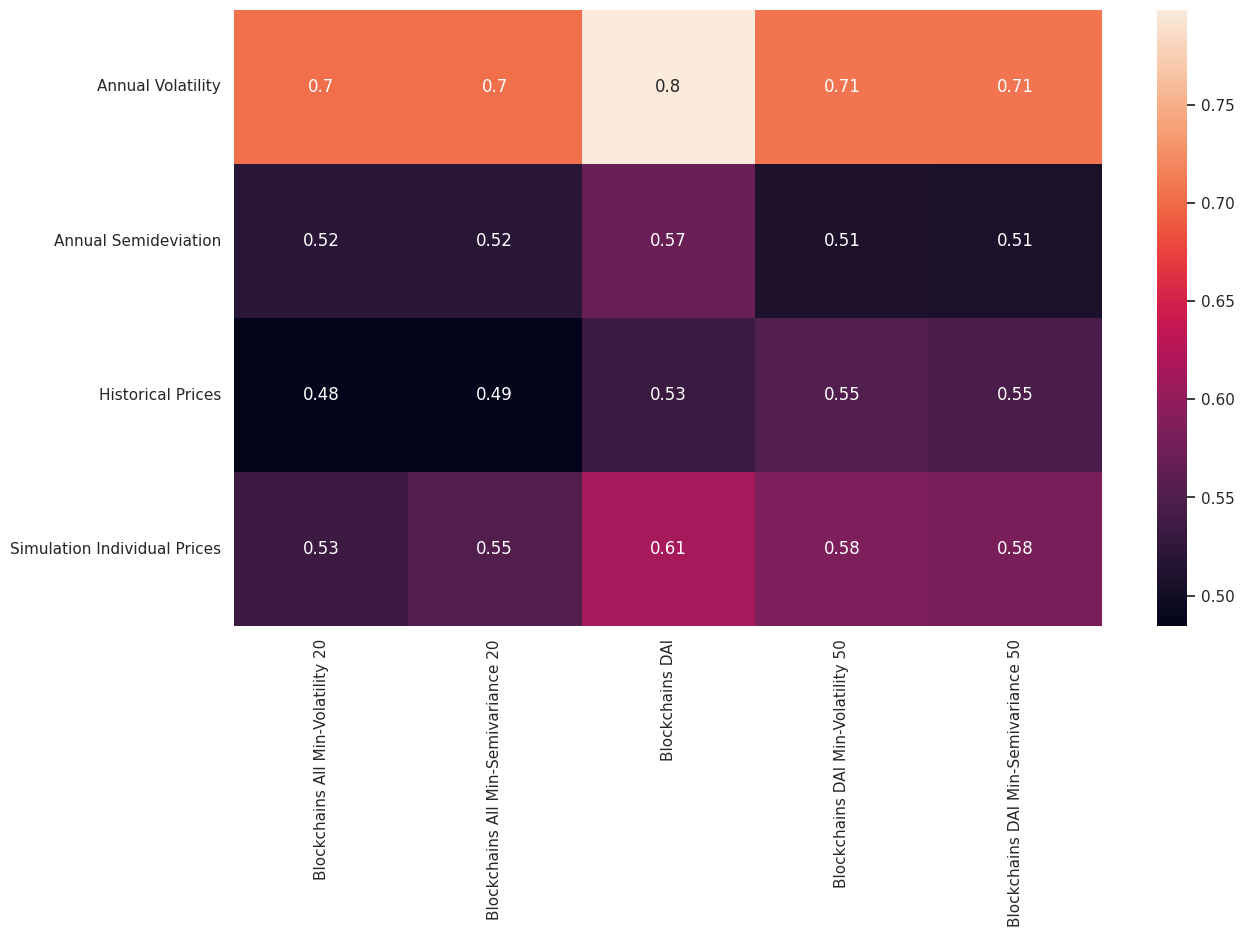

In [142]:
table = test_porfolios([HistoricalSimulation, SimulationPrices])
# table = test_porfolios([HistoricalSimulation])

In [140]:
print(table.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & Blockchains All Min-Volatility 20 & Blockchains All Min-Semivariance 20 & Blockchains DAI & Blockchains DAI Min-Volatility 50 & Blockchains DAI Min-Semivariance 50 \\
\midrule
Annual Volatility & 0.702824 & 0.703038 & 0.798229 & 0.706982 & 0.707372 \\
Annual Semideviation & 0.519969 & 0.519577 & 0.570022 & 0.508097 & 0.506879 \\
Historical Prices & 0.484663 & 0.486415 & 0.532866 & 0.550833 & 0.546450 \\
Simulation Individual Prices & 0.526000 & 0.546000 & 0.619000 & 0.575000 & 0.592000 \\
\bottomrule
\end{tabular}

